In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.LNK_data import *
from torchdeepretina.utils import *
from kinetic.notebook.functions import *

channel without filter

In [10]:
device = torch.device('cuda:3')
model = KineticsChannelModel().to(device)
cfg = get_custom_cfg('channel')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel/epoch_080_loss_-3.33_pearson_0.4375.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.001)

In [11]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.57570679570623

In [5]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1, shuffle=True)
test_pc, _, _ = pearsonr_eval(model, test_data, 5, device)
test_pc

0.15161894836633308

In [11]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [ 1.0000],
        [-1.0000],
        [ 1.0000],
        [ 1.0000]], device='cuda:1')
kinetics.kfi tensor([[ 0.9982],
        [ 0.9220],
        [ 0.9997],
        [ 0.8444],
        [ 0.9985],
        [ 0.2441],
        [-0.9991],
        [ 0.9999]], device='cuda:1')
kinetics.kfr tensor([[-1.0000],
        [-0.9783],
        [ 0.6897],
        [ 0.6736],
        [ 1.0000],
        [-0.8782],
        [ 1.0000],
        [ 0.9782]], device='cuda:1')
kinetics.ksi tensor([[-8.0042e-05],
        [ 5.8578e-04],
        [ 1.5829e-04],
        [-1.5062e-04],
        [ 2.6461e-03],
        [ 5.4800e-04],
        [ 8.2148e-04],
        [ 1.5230e-04]], device='cuda:1')
kinetics.ksr tensor([[-8.3430e-06],
        [-7.4978e-06],
        [ 5.8411e-06],
        [ 2.1855e-06],
        [-1.8767e-05],
        [-6.5332e-07],
        [-7.8537e-06],
        [ 1.7386e-05]], device='cuda:1')


(0, 1)

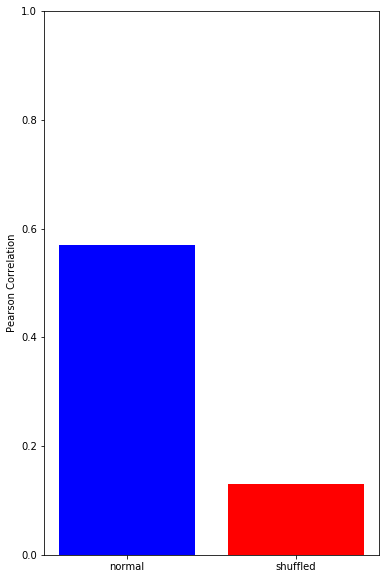

In [24]:
fig, ax = plt.subplots(figsize=(6,10))
rects1 = ax.bar(['normal', 'shuffled'], [0.57, 0.13], color=['blue', 'red'])
ax.set_ylabel('Pearson Correlation')
ax.set_ylim([0, 1])

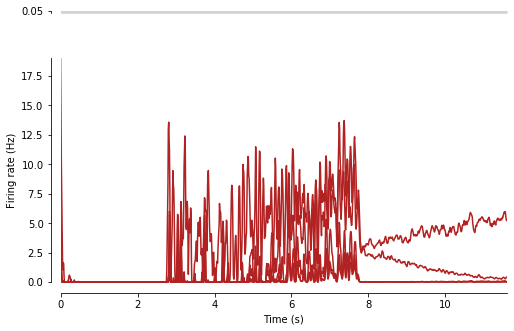

In [10]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=500, delay=300, nsamples=1200, nrepeats=3)

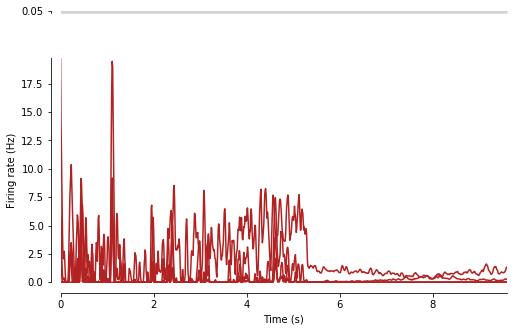

In [13]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3)

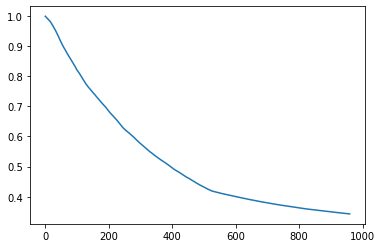

In [14]:
plt.plot(np.arange(960),Rs)

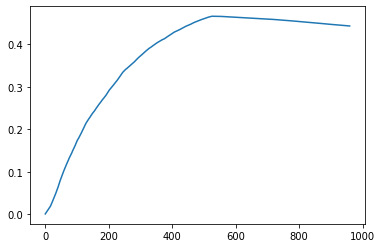

In [15]:
plt.plot(np.arange(960),As)

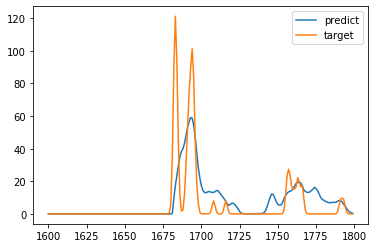

In [12]:
plt.plot(np.arange(1600,1800),pred[1600:1800,3], label='predict')
plt.plot(np.arange(1600,1800),targ[1600:1800,3], label='target')
plt.legend()

In [7]:
targ.shape

(5956, 5)

In [6]:
test_dataset = TestDataset(cfg)
batch_sampler = BatchRnnSampler(length=len(test_dataset), batch_size=1, seq_len=cfg.Data.seq_len)
test_data = DataLoader(dataset=test_dataset, batch_sampler=batch_sampler)

In [16]:
def inspect_rnn(model, curr_hs, data, device=torch.device('cuda:1')):
    hs = []
    hs.append(curr_hs[0].detach())
    hs.append(deque([h.detach() for h in curr_hs[1]], maxlen=model.seq_len))
    data = data.to(device)
    for x in data:
        x = x[None,:,:,:]
        out, hs = model(x, hs)
    return out

def stimulus_importance_rnn(model, X, gc_idx=None, alpha_steps=5, 
                            seq_len=8, device=torch.device('cuda:1')):
    
    requires_grad(model, False) # Model gradient unnecessary for integrated gradient
    prev_grad_state = torch.is_grad_enabled() # Save current grad calculation state
    torch.set_grad_enabled(True) # Enable grad calculations
    
    if gc_idx is None:
        gc_idx = list(range(model.n_units))
    intg_grad = torch.zeros(seq_len, *model.image_shape)
    curr_hs = get_hs(model, 1, device)
    model = model.to(device)
    model.eval()
    X = torch.FloatTensor(X)
    X.requires_grad = True
    idxs = torch.arange(len(X)).long()
    for start_idx in range(0, len(X) - seq_len):
        linspace = torch.linspace(0,1,alpha_steps)
        idx = idxs[start_idx: start_idx + seq_len]
        with torch.no_grad():
            out, next_hs = model(X[start_idx][None,:,:,:].to(device), curr_hs)
        curr_intg_grad = torch.zeros(seq_len, *model.image_shape)
        for alpha in linspace:
            x = X[idx].to(device) * alpha
            outs = inspect_rnn(model, curr_hs, x)[:,gc_idx]
            grad = torch.autograd.grad(outs.sum(), x)[0]
            grad = grad.detach().cpu().reshape(*intg_grad.shape)
            act = X[idx].detach().cpu()
            curr_intg_grad += grad*act
        intg_grad += torch.mul(curr_intg_grad, curr_intg_grad) / (len(X) - seq_len)
        curr_hs = next_hs
            
    requires_grad(model, True)
    torch.set_grad_enabled(prev_grad_state)
    
    intg_grad = intg_grad.view(seq_len * model.image_shape[0], *model.image_shape[1:])
    intg_grad = torch.mean(intg_grad, dim=(1,2))
    intg_grad = torch.sqrt(intg_grad)
    intg_grad = intg_grad.data.cpu().numpy()
    return intg_grad

In [15]:
data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'test',
                        cfg.img_shape[0], 0, data_path=cfg.Data.data_path)
X = data.X[0:1000]
intg_grad = stimulus_importance_rnn(model, X, alpha_steps=5)

[Text(0, 0.5, 'Importance'), Text(0.5, 0, 't / frame')]

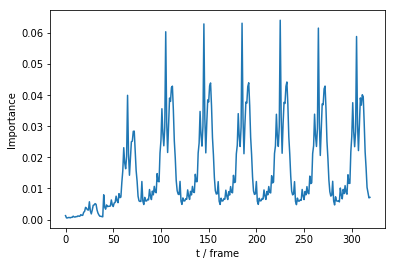

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(320), intg_grad)
ax.set(xlabel='t / frame', ylabel='Importance')

channel model with a temperal filter

In [40]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter/epoch_10_loss_-27.42987749385597_pearson_0.45068423074452113.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilter(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0

In [3]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.6206136744202656

In [41]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
for reset_int in [600, 800, 1000, 2000, 4000, 5965]:
    pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, reset_int, device)
    print(reset_int, pc)

600 0.6206136744202656
800 0.6087829141714115
1000 0.5603319456965922
2000 0.47476056269249717
4000 0.41067667930663604
5965 0.3098852581300601


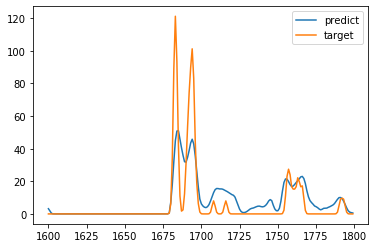

In [4]:
plt.plot(np.arange(1600,1800),pred[1600:1800,3], label='predict')
plt.plot(np.arange(1600,1800),targ[1600:1800,3], label='target')
plt.legend()

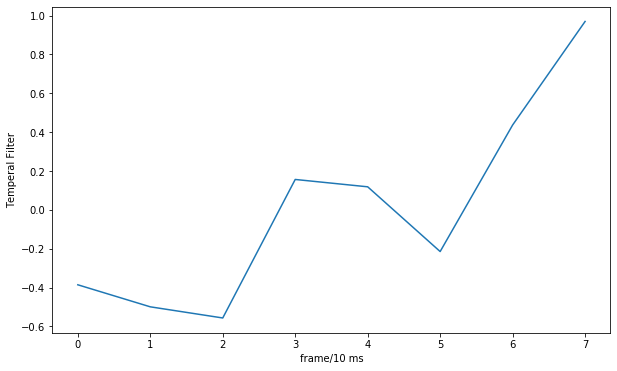

In [7]:
filter = checkpoint['model_state_dict']['amacrine.1.filter'].cpu().numpy().squeeze()
fig, ax = plt.subplots(figsize=(10,6))
ax.set_ylabel('Temperal Filter')
ax.set_xlabel('frame/10 ms')
plt.plot(np.arange(8),filter)

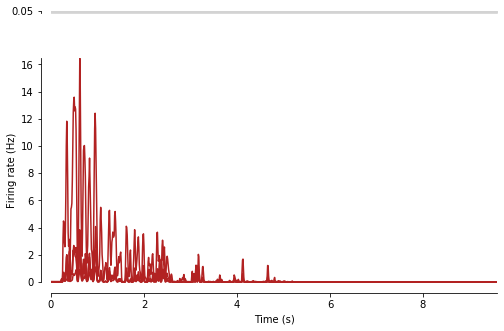

In [17]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=10)

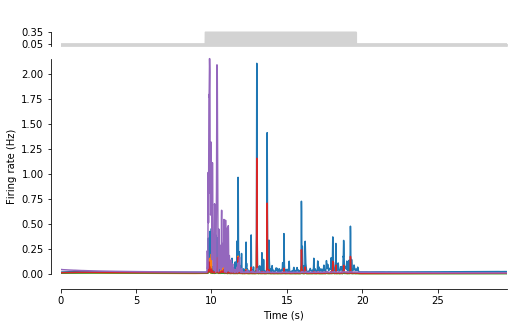

In [19]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

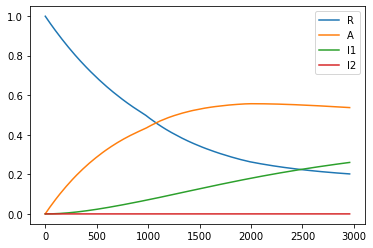

In [21]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label= 'A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.legend()

In [28]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural(model, device, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

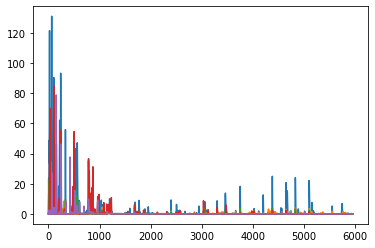

In [29]:
plt.plot(np.arange(responses.shape[0]), responses)

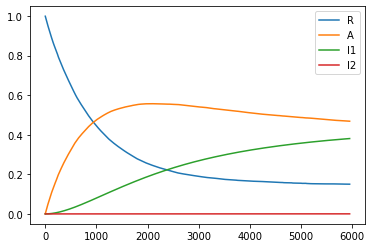

In [31]:
plt.plot(np.arange(5956),Rs, label='R')
plt.plot(np.arange(5956),As, label= 'A')
plt.plot(np.arange(5956),I1s, label='I1')
plt.plot(np.arange(5956),I2s, label='I2')
plt.legend()

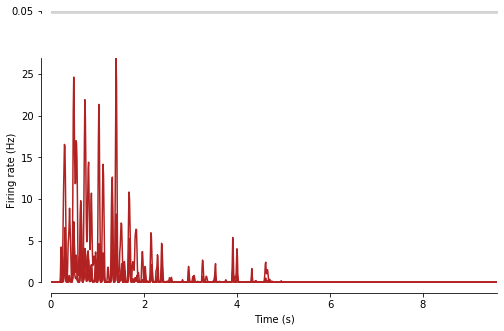

In [22]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_occupancy(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3)

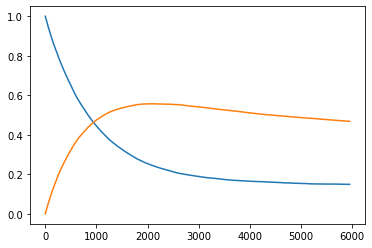

In [19]:
plt.plot(np.arange(960),Rs)
plt.plot(np.arange(960),As)

In [17]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy_natural(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

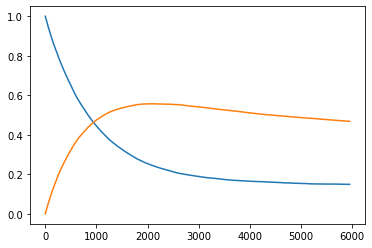

In [20]:
plt.plot(np.arange(5956),Rs)
plt.plot(np.arange(5956),As)

In [11]:
test_data[1][0].shape

torch.Size([40, 50, 50])

In [5]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[1.5426],
        [0.3703],
        [0.9160],
        [0.9499],
        [0.9340],
        [0.9816],
        [1.2149],
        [0.9078]], device='cuda:0')
kinetics.kfi tensor([[-0.2491],
        [ 0.4618],
        [ 0.2080],
        [ 0.4353],
        [ 0.4470],
        [ 0.3863],
        [ 0.2987],
        [ 0.2215]], device='cuda:0')
kinetics.kfr tensor([[ 8.0158e-01],
        [ 7.1081e-04],
        [-5.1790e-01],
        [ 9.2692e-01],
        [ 4.2982e-03],
        [ 6.4378e-01],
        [ 7.7946e-01],
        [-3.6091e-01]], device='cuda:0')
kinetics.ksi tensor([[-5.9985e-04],
        [-4.0659e-06],
        [-9.8312e-05],
        [ 3.2299e-04],
        [-1.3978e-05],
        [-4.8541e-04],
        [ 7.2575e-04],
        [-3.3857e-04]], device='cuda:0')
kinetics.ksr tensor([[ 1.4934e-06],
        [-4.0375e-11],
        [-1.0972e-06],
        [-1.0833e-05],
        [-8.4881e-11],
        [ 3.2628e-06],
        [ 1.4778e-05],
        [-3.9474e-08]], device='cuda:0'

channel filter model after fine tuing the rate constants using 50-len dataset

In [2]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_slow')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_slow/epoch_002_loss_-2.99_pearson_0.4736.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilter(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Softplus(beta=1, threshold=20)
    (5): Clamp()
    (6): Multiply()
    (7): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0

In [6]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[0.9475],
        [0.8159],
        [0.9771],
        [0.7919],
        [0.9453],
        [0.8805],
        [0.9745],
        [0.8654]], device='cuda:3')
kinetics.kfi tensor([[-0.4885],
        [ 0.0040],
        [ 0.1654],
        [ 0.5738],
        [ 0.5581],
        [ 0.5137],
        [ 0.5351],
        [ 0.0793]], device='cuda:3')
kinetics.kfr tensor([[ 0.0073],
        [ 1.0506],
        [-1.0630],
        [ 1.3895],
        [ 0.0185],
        [ 1.1836],
        [ 0.4049],
        [-0.9492]], device='cuda:3')
kinetics.ksi tensor([[-6.1182e-01],
        [-2.2900e-04],
        [-4.4565e-03],
        [-7.2793e-03],
        [-3.1899e-01],
        [ 4.0868e-03],
        [ 3.6434e-01],
        [ 4.3367e-03]], device='cuda:3')
kinetics.ksr tensor([[-2.5764e-04],
        [-2.4422e-01],
        [-2.9915e-01],
        [-1.5847e-01],
        [ 1.0186e-01],
        [ 2.7667e-01],
        [-6.5591e-03],
        [ 4.0603e-01]], device='cuda:3')


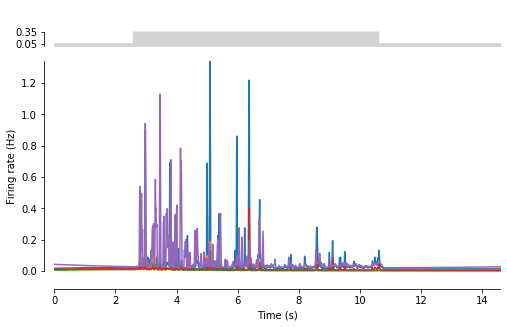

In [4]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

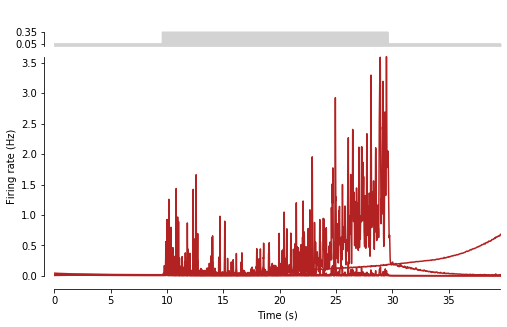

In [7]:
figs, envelope, responses = contrast_adaptation_kinetic(model, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

In [12]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

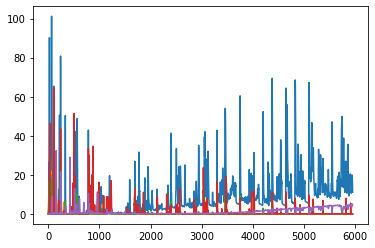

In [15]:
plt.plot(np.arange(responses.shape[0]), responses)

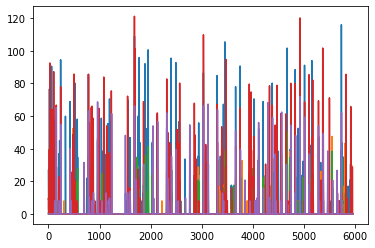

In [16]:
plt.plot(np.arange(targets.shape[0]), targets)

In [18]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural_reset(model, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

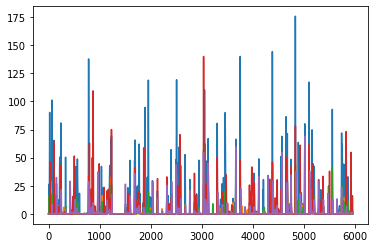

In [19]:
plt.plot(np.arange(responses.shape[0]), responses)

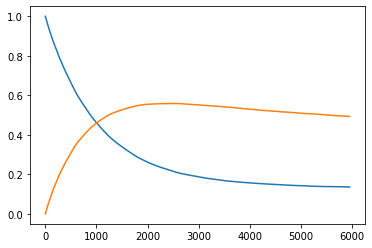

In [10]:
plt.plot(np.arange(5956),Rs)
plt.plot(np.arange(5956),As)

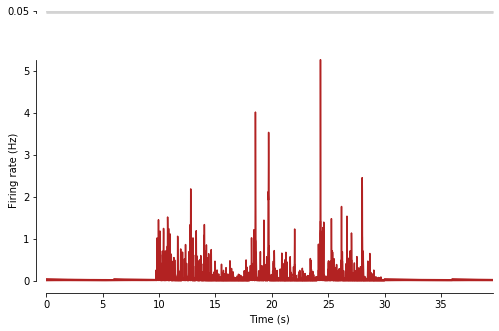

In [24]:
figs, envelope, responses = contrast_adaptation_kinetic_reset(model, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

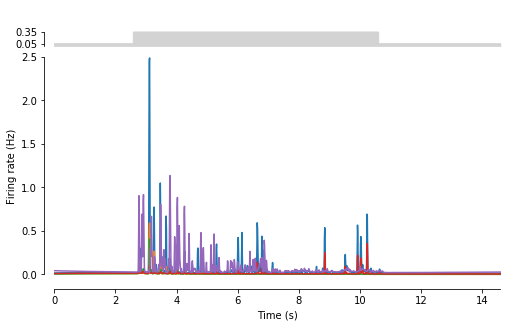

In [4]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_occupancy(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

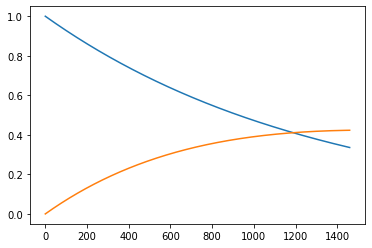

In [6]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

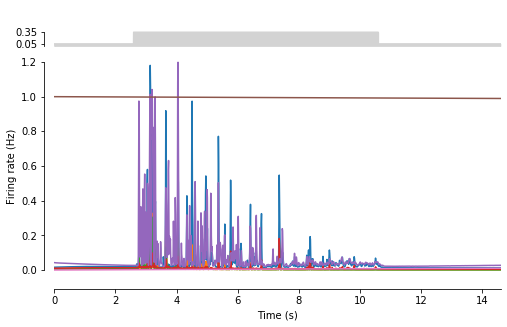

In [7]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

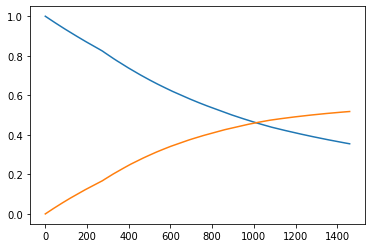

In [8]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

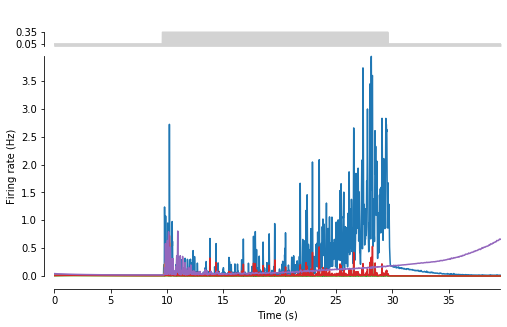

In [7]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=2000, delay=1000, nsamples=4000, nrepeats=10)

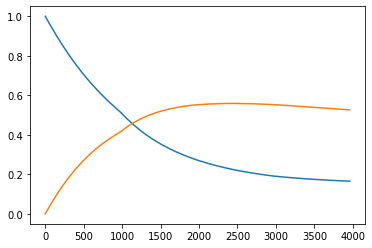

In [8]:
plt.plot(np.arange(3960),Rs)
plt.plot(np.arange(3960),As)

In [5]:
Rs = contrast_adaptation_kinetic_center_deviation(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

(array([8679.,  509.,  229.,  180.,  150.,  215.,  122.,  147.,   85.,
          52.]),
 array([  0.        ,  60.89805123, 121.79610246, 182.69415369,
        243.59220492, 304.49025615, 365.38830738, 426.28635861,
        487.18440984, 548.08246107, 608.9805123 ]),
 <a list of 10 Patch objects>)

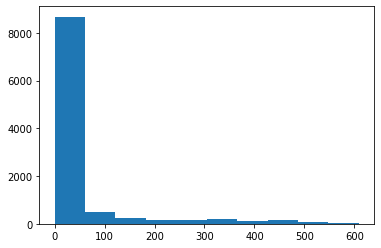

In [6]:
plt.hist(Rs.flatten())

In [9]:
int(np.where(Rs==Rs.max())[0])

7

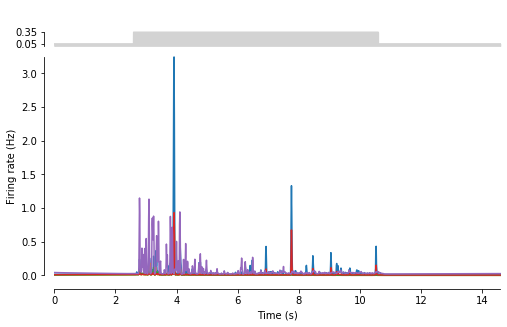

In [10]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_where_occupancy(model, device, c0=0.05, c1=0.35, where=(7,444), duration=800, delay=300, nsamples=1500, nrepeats=10)

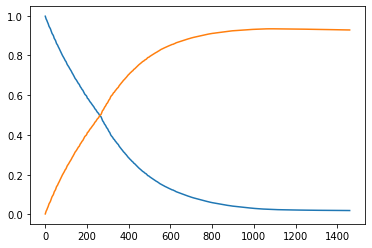

In [20]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

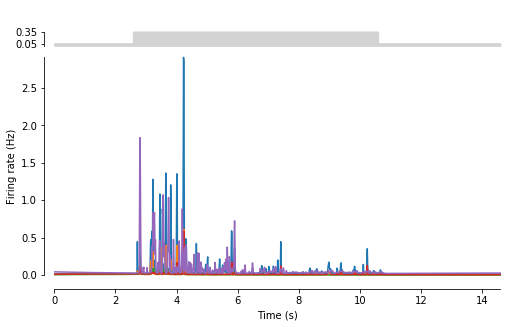

In [5]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_center_deviation_response(model, device, c0=0.05, c1=0.35, duration=800, delay=300, nsamples=1500, nrepeats=10)

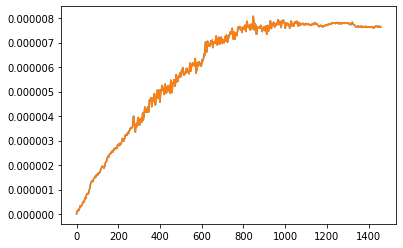

In [6]:
plt.plot(np.arange(1460),Rs)
plt.plot(np.arange(1460),As)

In [5]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.6460017342818717

In [21]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.35493691587280857

use sigmoid instead of relu+clamp, initialize kinetic parameters using LNK paper

In [51]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK/epoch_005_loss_-30.11_pearson_0.5084.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.01)
  (kinet_scale): ScaleShift(shape=(8, 8, 1296)

In [52]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.6942813021820896

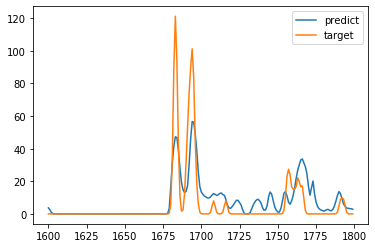

In [6]:
plt.plot(np.arange(1600,1800),pred[1600:1800,3], label='predict')
plt.plot(np.arange(1600,1800),targ[1600:1800,3], label='target')
plt.legend()

In [14]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[22.4303],
        [22.3575],
        [22.4132],
        [22.8799],
        [22.6841],
        [22.5745],
        [22.7075],
        [22.7856]], device='cuda:3')
kinetics.kfi tensor([[47.4921],
        [47.8770],
        [48.4854],
        [48.7167],
        [47.6574],
        [48.5394],
        [48.4134],
        [48.0832]], device='cuda:3')
kinetics.kfr tensor([[83.2130],
        [83.2230],
        [83.2236],
        [83.2386],
        [83.2219],
        [83.2163],
        [83.2480],
        [83.2506]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


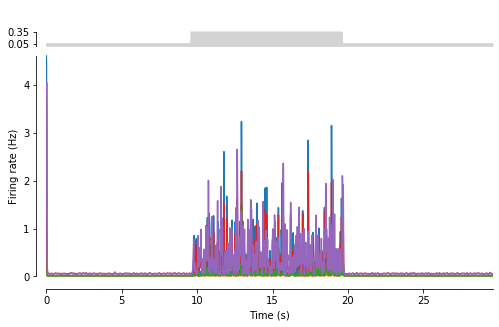

In [24]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

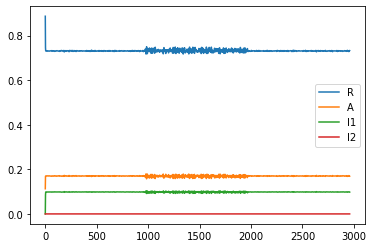

In [25]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label='A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.legend()

In [33]:
test_data =  TestDataset(cfg)
Rs, As, I1s, I2s, responses, targets = contrast_adaptation_kinetic_occupancy_natural(model, device, c0=0.05, c1=0.35, duration=500, delay=50, nsamples=1000, nrepeats=3, stimuli=test_data)

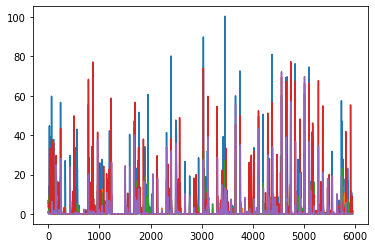

In [34]:
plt.plot(np.arange(responses.shape[0]), responses)

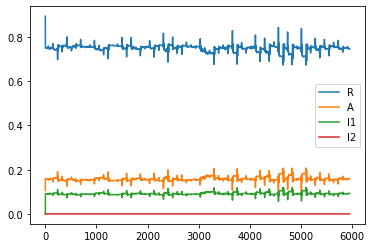

In [36]:
plt.plot(np.arange(5956),Rs, label='R')
plt.plot(np.arange(5956),As, label='A')
plt.plot(np.arange(5956),I1s, label='I1')
plt.plot(np.arange(5956),I2s, label='I2')
plt.legend()

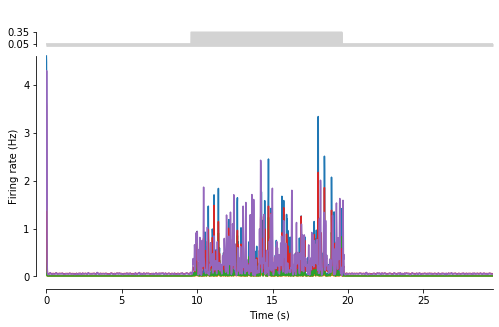

In [4]:
averages = contrast_adaptation_kinetic_average(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

In [8]:
averages.shape

(10, 2960, 5)

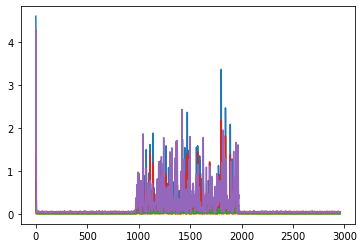

In [9]:
averages = averages.mean(axis=0)
plt.plot(np.arange(averages.shape[0]), averages)

fine tune the last model

In [8]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_slow/epoch_002_loss_-3.40_pearson_0.5127.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.01)
  (kinet_scale): ScaleShift(shape=(8, 8, 1296)

In [9]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.6957634717840353

In [11]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[22.7190],
        [22.8856],
        [22.9204],
        [23.5034],
        [21.8238],
        [22.5526],
        [22.6044],
        [21.7474]], device='cuda:3')
kinetics.kfi tensor([[47.3202],
        [47.6124],
        [48.0920],
        [48.1205],
        [48.5648],
        [48.3985],
        [48.4057],
        [49.1314]], device='cuda:3')
kinetics.kfr tensor([[83.9286],
        [83.2420],
        [83.2765],
        [83.6169],
        [82.3054],
        [83.5892],
        [82.7349],
        [82.0968]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


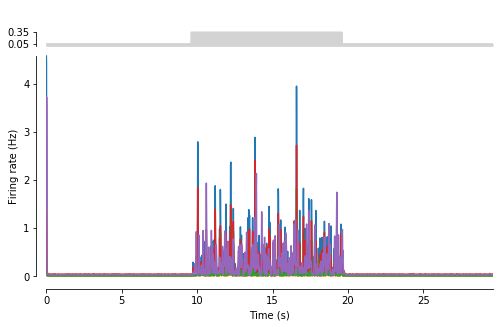

In [10]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

initialize the last two layers using linear stacked BNCNN model, but not fix them

In [2]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_bipolar')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_bipolar/epoch_020_loss_-32.50_pearson_0.5323.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.01)
  (kinet_scale): ScaleShift(shape=(8, 8, 1296)

In [43]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.7103706195602885

In [75]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1, shuffle=True)
test_pc, _, _ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.09309597123966556

(0, 1)

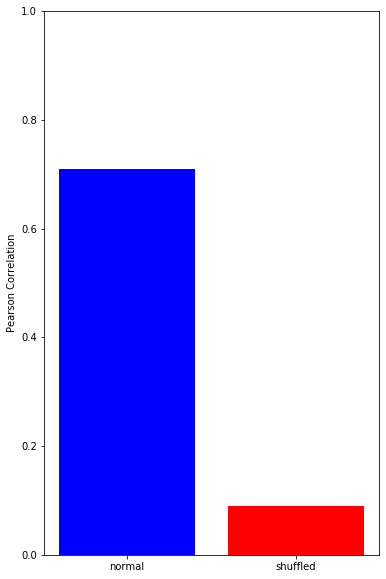

In [76]:
fig, ax = plt.subplots(figsize=(6,10))
rects1 = ax.bar(['normal', 'shuffled'], [0.71, 0.09], color=['blue', 'red'])
ax.set_ylabel('Pearson Correlation')
ax.set_ylim([0, 1])

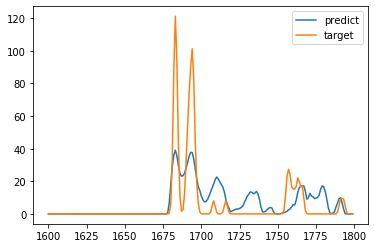

In [46]:
plt.plot(np.arange(1600,1800),pred[1600:1800,3], label='predict')
plt.plot(np.arange(1600,1800),targ[1600:1800,3], label='target')
plt.legend()

In [47]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[25.6189],
        [26.8336],
        [29.9215],
        [36.6989],
        [25.6443],
        [34.6685],
        [32.5884],
        [30.9607]], device='cuda:3')
kinetics.kfi tensor([[26.1393],
        [33.3481],
        [25.1163],
        [22.2640],
        [22.4539],
        [29.0222],
        [27.9760],
        [20.6414]], device='cuda:3')
kinetics.kfr tensor([[49.0325],
        [49.6406],
        [49.0750],
        [50.8204],
        [48.9798],
        [50.3990],
        [49.9653],
        [49.4100]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


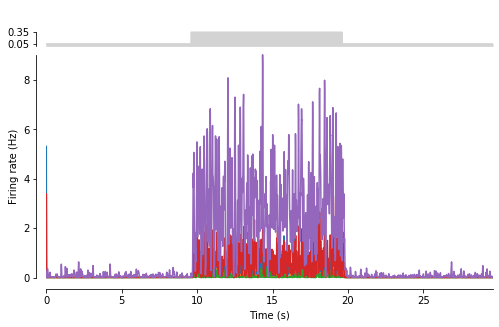

In [3]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

((<Figure size 576x360 with 2 Axes>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x7f913e8aab70>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f913a7a0b38>)),
 array([[[0.05]],
 
        [[0.05]],
 
        [[0.05]],
 
        ...,
 
        [[0.05]],
 
        [[0.05]],
 
        [[0.05]]]),
 array([[[4.8273201e+00, 7.5766671e-01, 3.4931490e+00, 3.0986552e+00,
          1.7097904e-01],
         [5.5519688e-01, 2.4942765e-02, 2.1867934e-01, 3.8263012e-02,
          8.9889830e-03],
         [3.4697035e-01, 1.5430523e-02, 9.4209991e-02, 2.5701730e-02,
          1.4912717e-02],
         ...,
         [8.2657389e-02, 5.3540245e-02, 2.1320756e-01, 2.3360746e-01,
          4.5470774e-06],
         [3.8015306e-02, 4.0419169e-02, 1.3234374e-01, 9.7302385e-02,
          1.2502537e-05],
         [1.8790890e-02, 2.9565731e-02, 7.6641582e-02, 4.2731341e-02,
          3.8736329e-05]],
 
        [[3.4816070e+00, 7.3982060e-01, 1.9462594e+00, 2.8250453e+00,
          9.8778956e-02],
         [5.1

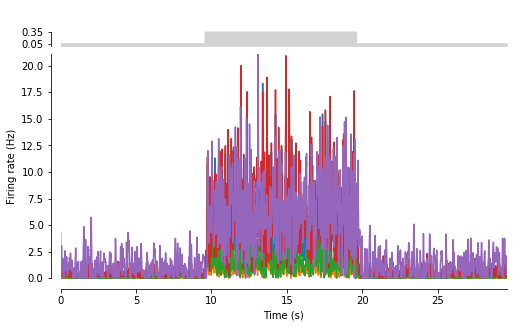

In [4]:
contrast_adaptation_kinetic(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

initialize the last two layers using linear stacked BNCNN model, and fix them

In [19]:
device = torch.device('cuda:1')
cfg = get_custom_cfg('channel_filter_bipolar')
model = select_model(cfg, device)
#checkpoint_path = '/home/xhding/saved_model/channel_filter/epoch_060_loss_-31.93_pearson_0.4651.pth'
checkpoint_path = '/home/xhding/saved_model/channel_filter_bipolar/epoch_000_loss_-15.35_pearson_0.3779.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel()
  (kinet_scale): ScaleShift(shape=(8, 8, 1296), scale

In [45]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.6508814074780555

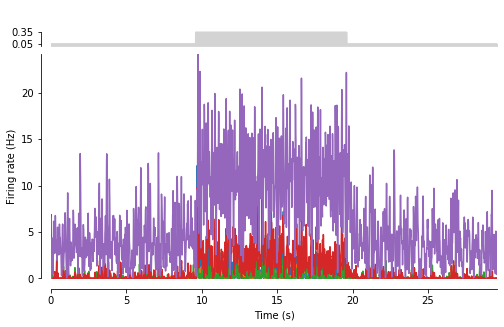

In [203]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=40, nrepeats=5)

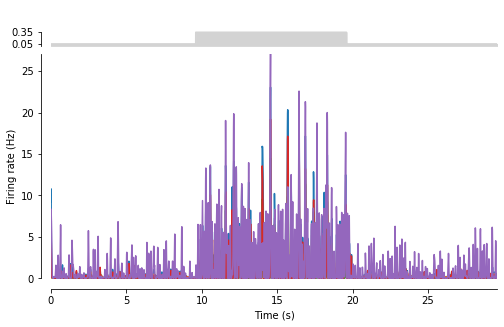

In [23]:
Rs, As, I1s, I2s, us, after_kinetics = contrast_adaptation_kinetic_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=40)

In [209]:
checkpoint['model_state_dict']['amacrine.1.filter'].squeeze()

tensor([15.4827, 15.4046, 15.9282, 16.0433, 15.1848, 14.9494, 15.1870, 18.2613],
       device='cuda:1')

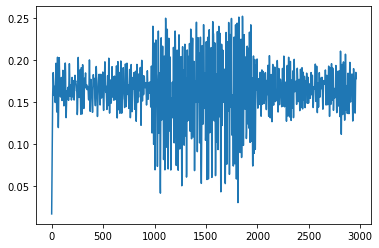

In [28]:
plt.plot(after_kinetics[:,0])

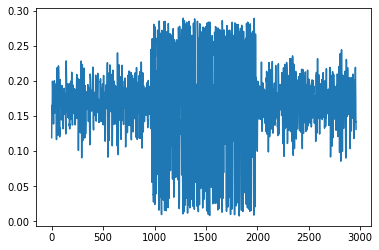

In [29]:
plt.plot(As[:,5])

In [4]:
checkpoint['model_state_dict'].keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.2.running_mean', 'bipolar.2.running_var', 'bipolar.2.num_batches_tracked', 'bipolar.3.sigma', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinet_scale.scale_param', 'kinet_scale.shift_param', 'amacrine.1.filter', 'amacrine.2.convs.0.weight', 'amacrine.2.convs.1.weight', 'amacrine.2.convs.2.weight', 'amacrine.2.convs.3.weight', 'amacrine.2.convs.4.weight', 'amacrine.2.convs.4.bias', 'amacrine.4.weight', 'amacrine.4.bias', 'amacrine.4.running_mean', 'amacrine.4.running_var', 'amacrine.4.num_batches_tracked', 'amacrine.5.sigma', 'ganglion.0.weight', 'ganglion.1.weight', 'ganglion.1.bias', 'ganglion.1.running_mean', 'ganglion.1.running_var', 'ganglion.1.num_batches_tracked'])

In [22]:
model.state_dict()['amacrine.4.running_mean']

tensor([-1.1852e-02, -1.4772e-02, -1.6236e-02,  ..., -1.5725e-05,
        -1.1422e-03,  2.1098e-04], device='cuda:1')

manually set the slow parameters

In [224]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_bipolar')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_bipolar/epoch_020_loss_-32.50_pearson_0.5323.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.kinetics.ksi.data = 0.2 * torch.ones(model.chans[0], 1).to(device)
model.kinetics.ksr.data = 0.02 * torch.ones(model.chans[0], 1).to(device)

TypeError: super(type, obj): obj must be an instance or subtype of type

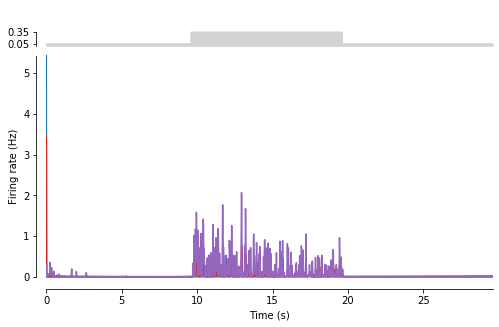

In [69]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

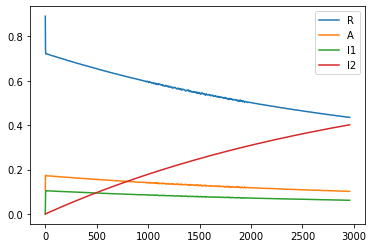

In [72]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label='A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.legend()

In [70]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.4828787565562436

only set sigmoid, not initialize with LNK parameters

In [2]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter/epoch_040_loss_-31.47_pearson_0.5131.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolar(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (4): Sigmoid()
    (5): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel(dt=0.01)
  (kinet_scale): ScaleShift(shape=(8, 8, 1296)

In [3]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[-3.3588],
        [ 2.3175],
        [ 2.6564],
        [ 5.0671],
        [ 2.9234],
        [ 2.6755],
        [ 1.3701],
        [ 2.9981]], device='cuda:3')
kinetics.kfi tensor([[3.0417e+00],
        [2.4369e+00],
        [2.8295e+00],
        [2.2911e+00],
        [5.0536e-04],
        [4.7237e-04],
        [2.6031e+00],
        [2.1027e-03]], device='cuda:3')
kinetics.kfr tensor([[ 2.5780],
        [ 2.2230],
        [ 0.7170],
        [-9.8261],
        [-0.2166],
        [-0.2047],
        [ 1.3676],
        [ 0.4223]], device='cuda:3')
kinetics.ksi tensor([[-2.3216e-02],
        [-1.1677e-02],
        [-1.8046e-01],
        [-3.0827e-04],
        [-1.2743e-03],
        [ 5.5478e-04],
        [-9.7476e-03],
        [ 1.1082e-04]], device='cuda:3')
kinetics.ksr tensor([[ 2.6198e-02],
        [ 9.3643e-03],
        [ 2.9480e-02],
        [ 5.5769e-02],
        [-6.9855e-06],
        [ 7.8349e-06],
        [-2.0058e-03],
        [ 1.6886e-05]], device='cuda:3'

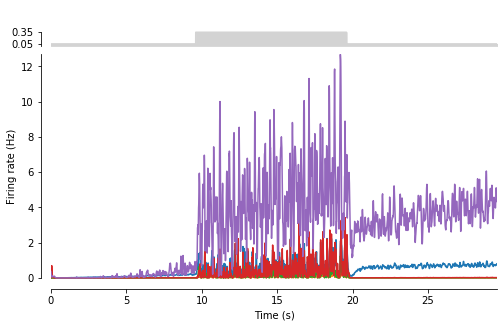

In [4]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

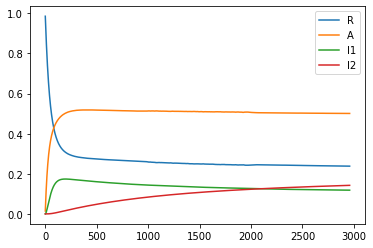

In [5]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label='A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.legend()

In [6]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.6608385753684219

In [7]:
test_data =  DataLoader(TestDataset(cfg), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 600, device)
test_pc

0.6747844467148202

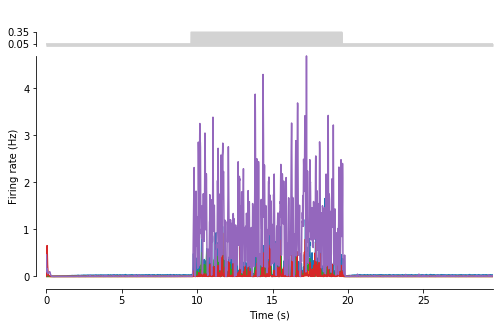

In [8]:
model.kinetics.ksi.data = 0. * torch.ones(model.chans[0], 1).to(device)
model.kinetics.ksr.data = 0. * torch.ones(model.chans[0], 1).to(device)
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

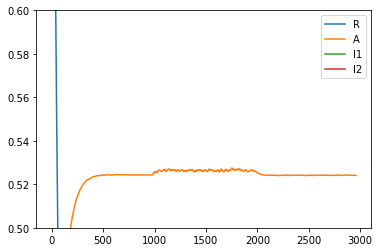

In [12]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label='A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.ylim(0.5, 0.6)
plt.legend()

In [14]:
cfg = get_custom_cfg('channel_filter')
train_dataset = TrainDataset(cfg)

In [17]:
train_dataset.stats['std']

53.62663279042969

In [3]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('one_pixel')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_-5.79_pearson_0.9700.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsOnePixelChannel(
  (kinetics): Kinetics_channel()
  (amacrine_filter): Temperal_Filter()
  (ganglion): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [3]:
model.dt = 0.001
stim, resp = generate('/home/xhding/workspaces/lnkmodelcell10.mat', 'LNK_stim', 0.001)
_, val_dataset, _ = organize(stim, resp[:,1], 40)
validation_data = DataLoader(dataset=val_dataset)
pearson = pearsonr_eval(model, validation_data, 1, len(validation_data), device)
pearson

0.07016084772065805

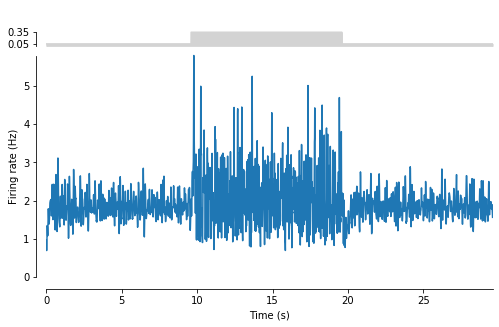

In [8]:
model.dt = 0.01
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy_onepixel(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

In [7]:
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_-5.79_pearson_0.9700.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 6.1014],
        [-2.9121],
        [ 3.0240],
        [-2.9341],
        [ 2.5176],
        [-3.1047],
        [ 6.0159],
        [-1.7234]], device='cuda:3')
kinetics.kfi tensor([[ 4.5042],
        [ 7.2033],
        [ 8.0489],
        [ 6.7661],
        [ 5.3660],
        [-5.2680],
        [11.9220],
        [ 5.4102]], device='cuda:3')
kinetics.kfr tensor([[-6.9117],
        [-4.6547],
        [-5.9097],
        [-4.4068],
        [ 7.9569],
        [-2.9438],
        [-4.4226],
        [-1.9714]], device='cuda:3')
kinetics.ksi tensor([[ 0.0385],
        [ 2.1452],
        [-0.3509],
        [ 0.0094],
        [ 0.0173],
        [-0.7790],
        [-0.2894],
        [ 1.7649]], device='cuda:3')
kinetics.ksr tensor([[-10.3689],
        [ -8.7378],
        [ -8.7170],
        [ -6.7533],
        [  6.8322],
        [  6.5926],
        [ -7.3658],
        [  3.4951]], device='cuda:3')


In [8]:
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_-0.28_pearson_0.6673.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[ 4.4602],
        [-3.6862],
        [-3.8883],
        [-0.5436],
        [-2.8694],
        [-1.2738],
        [ 0.2395],
        [ 2.0975]], device='cuda:3')
kinetics.kfi tensor([[ -7.4338],
        [-13.2089],
        [ -4.6435],
        [  3.4142],
        [ -8.3096],
        [ -1.7785],
        [ -4.9760],
        [ -3.9611]], device='cuda:3')
kinetics.kfr tensor([[ -0.6259],
        [ -2.2007],
        [  1.1571],
        [ -3.0519],
        [-11.5322],
        [ -3.5068],
        [ -0.2661],
        [  1.4996]], device='cuda:3')
kinetics.ksi tensor([[ 0.0249],
        [-0.0246],
        [-0.0055],
        [-1.2963],
        [ 0.0474],
        [-0.3772],
        [ 0.4861],
        [-0.0796]], device='cuda:3')
kinetics.ksr tensor([[-1.9122],
        [ 3.2999],
        [-6.5155],
        [-3.0061],
        [-2.5438],
        [ 2.5986],
        [-0.2259],
        [ 0.1760]], device='cuda:3')


In [9]:
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_0.59_pearson_0.4896.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[-0.8861],
        [ 0.3055],
        [ 0.6941],
        [-1.6085],
        [-0.1982],
        [ 1.2214],
        [ 0.1324],
        [-1.4369]], device='cuda:3')
kinetics.kfi tensor([[ 3.2715],
        [-4.6502],
        [-3.9928],
        [-3.3058],
        [-5.7826],
        [ 1.5855],
        [-3.4249],
        [ 7.6837]], device='cuda:3')
kinetics.kfr tensor([[-0.7970],
        [-1.8724],
        [-0.6893],
        [ 1.1251],
        [ 1.3156],
        [ 2.8740],
        [ 0.8766],
        [-3.7113]], device='cuda:3')
kinetics.ksi tensor([[-3.4016e-06],
        [ 1.4792e+00],
        [-1.5056e+00],
        [-3.8644e-06],
        [ 8.9060e-01],
        [-2.8935e+00],
        [ 5.5629e-01],
        [-1.5835e-06]], device='cuda:3')
kinetics.ksr tensor([[-0.4511],
        [-1.3191],
        [ 0.4477],
        [ 4.1942],
        [ 0.5642],
        [-4.9698],
        [-0.5627],
        [ 1.9732]], device='cuda:3')


In [154]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_020_loss_-29.92_pearson_0.1584.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolarNoNorm(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (2): Sigmoid()
    (3): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel()
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 8, 36, 36))
    (1): Temperal_Filter()
    (2): LinearStackedConv2d(
      bias=True, abs_bnorm=False


In [163]:
for name, param in model.amacrine.named_parameters():
    #if 'filter' not in name:
        print(name)

1.filter
2.convs.0.weight
2.convs.1.weight
2.convs.2.weight
2.convs.3.weight
2.convs.4.weight
2.convs.4.bias
4.sigma


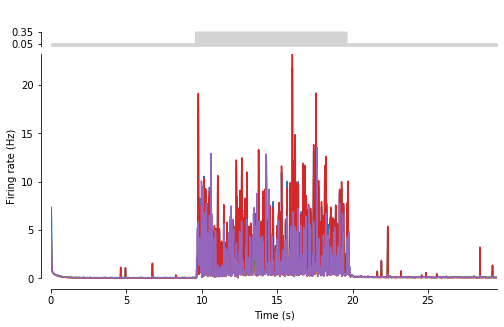

In [3]:
Rs, As, I1s, I2s = contrast_adaptation_kinetic_occupancy_2(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, nrepeats=10)

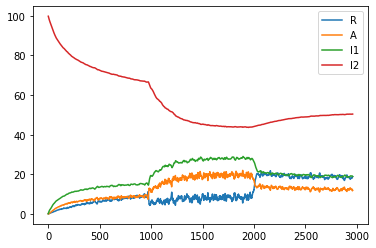

In [4]:
plt.plot(np.arange(2960),Rs, label='R')
plt.plot(np.arange(2960),As, label='A')
plt.plot(np.arange(2960),I1s, label='I1')
plt.plot(np.arange(2960),I2s, label='I2')
plt.legend()

In [9]:
test_data =  DataLoader(TestDataset(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc = pearsonr_eval_2(model, test_data, 5, 600, device)
test_pc

0.5529387708225275

In [10]:
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_0.59_pearson_0.4896.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[-0.8861],
        [ 0.3055],
        [ 0.6941],
        [-1.6085],
        [-0.1982],
        [ 1.2214],
        [ 0.1324],
        [-1.4369]], device='cuda:3')
kinetics.kfi tensor([[ 3.2715],
        [-4.6502],
        [-3.9928],
        [-3.3058],
        [-5.7826],
        [ 1.5855],
        [-3.4249],
        [ 7.6837]], device='cuda:3')
kinetics.kfr tensor([[-0.7970],
        [-1.8724],
        [-0.6893],
        [ 1.1251],
        [ 1.3156],
        [ 2.8740],
        [ 0.8766],
        [-3.7113]], device='cuda:3')
kinetics.ksi tensor([[-3.4016e-06],
        [ 1.4792e+00],
        [-1.5056e+00],
        [-3.8644e-06],
        [ 8.9060e-01],
        [-2.8935e+00],
        [ 5.5629e-01],
        [-1.5835e-06]], device='cuda:3')
kinetics.ksr tensor([[-0.4511],
        [-1.3191],
        [ 0.4477],
        [ 4.1942],
        [ 0.5642],
        [-4.9698],
        [-0.5627],
        [ 1.9732]], device='cuda:3')


In [58]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK2')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_UniScale/epoch_015_loss_-32.17_pearson_0.5022.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)

In [59]:
model.state_dict()['bipolar_bias']

tensor([-1.3100, -0.2659, -0.6139,  0.1645, -0.1557, -0.6275,  0.2974,  0.4974],
       device='cuda:3')

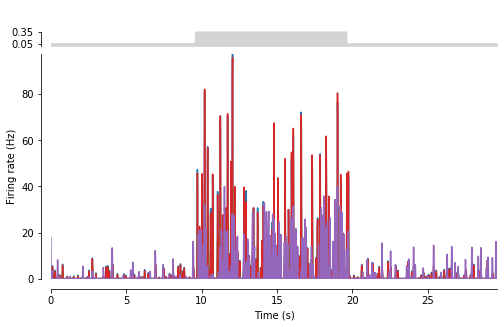

In [60]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000)

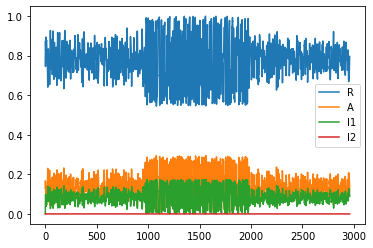

In [140]:
channel = 5
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [141]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[21.3547],
        [21.8674],
        [21.9353],
        [21.9047],
        [23.5761],
        [23.1219],
        [23.4438],
        [22.3028]], device='cuda:3')
kinetics.kfi tensor([[48.1328],
        [45.0492],
        [45.6261],
        [49.4612],
        [47.7855],
        [48.8029],
        [47.7009],
        [48.8156]], device='cuda:3')
kinetics.kfr tensor([[76.9783],
        [76.9964],
        [77.0387],
        [77.6366],
        [78.7512],
        [78.9583],
        [77.9604],
        [77.6688]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


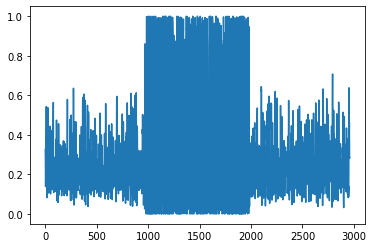

In [62]:
plt.plot(us[:,0])

In [143]:
model.state_dict()['amacrine_filter.filter']

tensor([[[0.1399]],

        [[0.0488]],

        [[0.1642]],

        [[0.4200]],

        [[0.3945]],

        [[0.2614]],

        [[0.3001]],

        [[0.6602]]], device='cuda:3')

In [144]:
model.state_dict()['kinet_scale.scale_param'], model.state_dict()['kinet_scale.shift_param']

(tensor([[[1.1276],
          [1.0123],
          [1.0851],
          [0.3212],
          [1.1927],
          [0.8727],
          [0.5232],
          [0.8408]],
 
         [[1.1540],
          [0.9935],
          [1.0417],
          [0.5214],
          [1.2108],
          [0.6378],
          [0.7966],
          [0.8286]],
 
         [[1.3357],
          [0.9901],
          [1.0700],
          [0.3635],
          [1.2526],
          [0.4172],
          [1.0237],
          [0.8321]],
 
         [[1.1000],
          [0.8946],
          [0.9390],
          [0.5545],
          [1.1136],
          [0.5422],
          [1.1715],
          [0.9664]],
 
         [[0.8319],
          [0.7613],
          [0.7861],
          [0.7945],
          [0.9564],
          [0.8527],
          [1.1367],
          [1.1062]],
 
         [[0.9154],
          [0.6079],
          [0.5661],
          [1.1102],
          [0.7431],
          [1.0656],
          [1.0110],
          [1.1622]],
 
         [[0.9751],
  

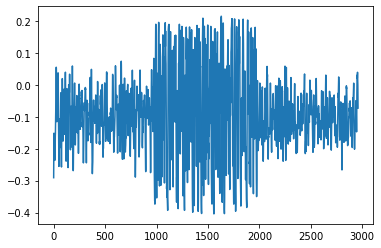

In [145]:
plt.plot(after_filters[:,5])

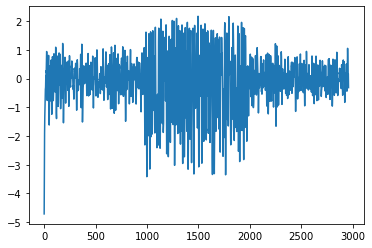

In [146]:
plt.plot(6.7*after_filters[:,5]+6.1*after_filters[:,7]+2.6*after_filters[:,6]-1.2*after_filters[:,0]+2*after_filters[:,1])

In [147]:
model.state_dict()['amacrine_weight']

tensor([[-5.3676e+00,  1.0115e+00,  1.7456e+00, -4.1744e+00,  5.6530e+00,
          3.2622e+00,  2.6929e+00, -7.3638e+00],
        [ 8.4628e-01, -7.7545e-01,  7.3145e-01,  1.3850e-01, -3.3030e+00,
          1.0469e+00,  2.0278e-01, -3.2390e+00],
        [-6.6789e+00,  5.5586e+00,  2.4195e+00, -3.6357e+00,  9.0139e-01,
          2.2451e+01,  8.4346e+00,  7.6290e+00],
        [-1.0426e+00,  1.0018e+00,  8.9928e-01, -7.7458e-01, -2.0761e+00,
          6.8733e+00,  2.5680e+00,  5.7125e-01],
        [-1.1840e+00,  1.9144e+00, -1.6101e-01, -3.5241e-01,  2.4409e-01,
          6.6587e+00,  2.5796e+00,  6.0673e+00],
        [-3.8628e+00,  1.1987e+00,  3.4990e-01, -2.7213e+00,  5.7074e+00,
          1.8769e+00,  2.0146e+00, -1.6007e+00],
        [-3.8194e-02,  2.1560e-01, -6.2282e-03,  8.0176e-02, -8.7945e-02,
          6.0938e-01,  1.0891e-01,  7.6830e-01],
        [-2.4237e+00,  1.6200e+00,  3.0005e+00, -1.4623e+00, -3.6333e+00,
          1.0613e+01,  2.7344e+00, -2.8360e+00]], device='cuda:3'

In [148]:
model.state_dict()['amacrine_bias']

tensor([-0.5316, -0.1181, -0.4754,  0.0597, -0.2268, -0.1875,  0.2508, -0.1168],
       device='cuda:3')

In [149]:
model.state_dict()['ganglion.0.weight']

tensor([[ 15.1410,   4.9819,  24.5645,  -0.4824,  14.8576,   8.5653, -14.6943,
          10.5378],
        [  4.1246,   6.0579,   3.3272,   2.4753,   8.9977,   3.0085, -17.9893,
           5.4723],
        [  6.9084,   7.7555,   7.3445,  -0.5752,  13.4809,   3.2120, -19.1121,
          -0.6743],
        [ 12.5149,   9.0378,  25.1189,  -5.7372,  15.3071,  12.3543, -16.7644,
          -0.1501],
        [ 10.1315,  33.7923,   9.8389, -31.2272,  -1.7225,  24.1562, -15.7070,
         -26.5445]], device='cuda:3')

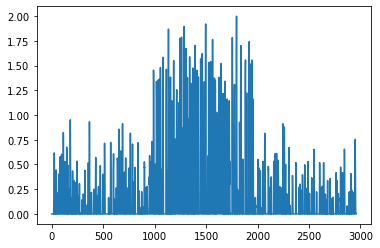

In [150]:
plt.plot(after_amacrines[:,4])

manually set thresholds of the first layer to 0

In [8]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK2')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_UniScale/epoch_015_loss_-32.17_pearson_0.5022.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict']['bipolar.0.convs.6.bias']=torch.tensor([-2., -2., -2., -2., -2., -2., -2., -2.]).to(device)
model = select_model(cfg, device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data =  DataLoader(TestDataset(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, targ = pearsonr_eval_with_responses(model, test_data, 5, 5956, device)
test_pc

0.3167854881969911

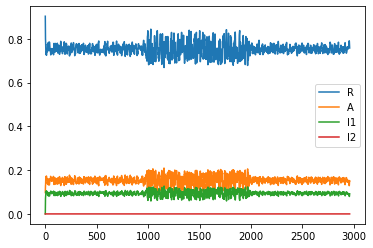

In [151]:
plt.plot(np.arange(2960),Rs.mean(-1), label='R')
plt.plot(np.arange(2960),As.mean(-1), label='A')
plt.plot(np.arange(2960),I1s.mean(-1), label='I1')
plt.plot(np.arange(2960),I2s.mean(-1), label='I2')
plt.legend()

fix bipolar bias = -4

In [4]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-29.58_pearson_0.4827.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)

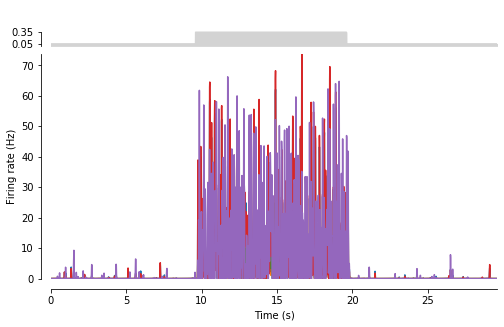

In [5]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000)

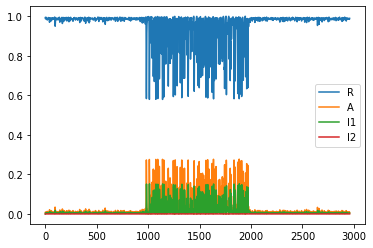

In [8]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [137]:
model.state_dict()['amacrine_bias']

tensor([ 0.0996, -0.1639, -0.3341, -0.1712, -0.2556, -0.0106, -0.4357, -0.0791],
       device='cuda:3')

initialize bipolar bias = -4

In [4]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)

In [5]:
checkpoint['model_state_dict']['bipolar.0.convs.6.bias']

tensor([-3.9833, -3.7619, -4.1185, -3.9373, -4.2727, -4.3724, -4.1833, -4.3114],
       device='cuda:3')

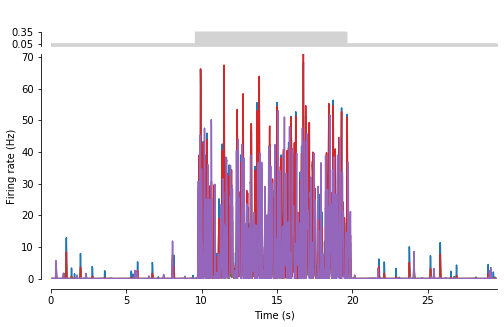

In [6]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000)

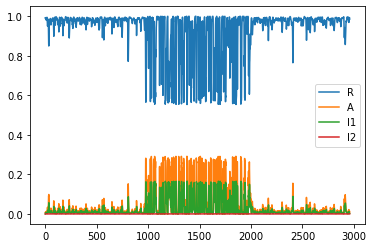

In [7]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [16]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[22.9447],
        [22.8235],
        [22.2651],
        [22.6211],
        [21.1537],
        [20.9708],
        [21.7308],
        [20.6105]], device='cuda:3')
kinetics.kfi tensor([[49.4040],
        [48.5468],
        [47.8037],
        [48.3992],
        [46.6788],
        [46.5758],
        [47.3925],
        [46.3800]], device='cuda:3')
kinetics.kfr tensor([[83.2092],
        [83.2386],
        [83.2122],
        [83.2238],
        [83.2059],
        [83.2050],
        [83.2112],
        [83.2028]], device='cuda:3')
kinetics.ksi tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')
kinetics.ksr tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:3')


In [20]:
I1s[:,1].mean()/As[:,1].mean()

0.58313227

In [23]:
checkpoint['model_state_dict']['kinetics.kfi'][1].data/checkpoint['model_state_dict']['kinetics.kfr'][1].data

tensor([0.5832], device='cuda:3')

In [8]:
channel = 1
ka = checkpoint['model_state_dict']['kinetics.ka'][channel].cpu().numpy()[0]
kfi = checkpoint['model_state_dict']['kinetics.kfi'][channel].cpu().numpy()[0]
kfr = checkpoint['model_state_dict']['kinetics.kfr'][channel].cpu().numpy()[0]
u_l = (us[:960, channel].mean() + us[2000:, channel].mean())/2
u_h = us[1000:1960, channel].mean()
A_l = (As[:960, channel].mean() + As[2000:, channel].mean())/2
A_h = As[1000:1960, channel].mean()
A_h -= 0.01
I1_l = kfi / kfr * A_l
I1_h = kfi / kfr * A_h

In [9]:
delta_I2_l = 1 - I1_l * (kfi*u_l*ka + kfr*u_l*ka + kfr*kfi) / (kfi*u_l*ka)
delta_I2_h = 1 - I1_h * (kfi*u_h*ka + kfr*u_h*ka + kfr*kfi) / (kfi*u_h*ka)
#alpha = u_h * I1_l / u_l / I1_h
alpha = I1_l / I1_h
I20 = (delta_I2_l - alpha*delta_I2_h) / (alpha - 1)
print(I20)

0.03077757237001977


In [13]:
decay_rate = 0.1
ksi = decay_rate / ((kfi*u_h*ka)/(kfi*u_h*ka + kfr*u_h*ka + kfr*kfi)+I1_h/(I20 + delta_I2_h))
ksr = I1_h / (I20 + delta_I2_h) * ksi
print(ksi, ksr)

0.397522731281456 0.07421999396695067


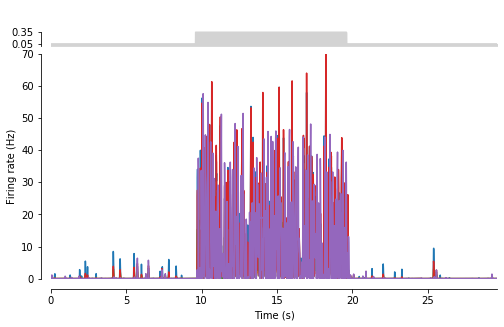

In [14]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)
model.kinetics.ksi.data = ksi * torch.ones(model.chans[0], 1).to(device)
model.kinetics.ksr.data = ksr * torch.ones(model.chans[0], 1).to(device)
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, I20=I20)

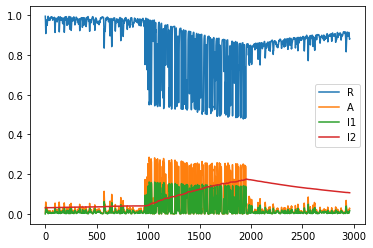

In [15]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [17]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.kinetics.ksi.data = ksi * torch.ones(model.chans[0], 1).to(device)
model.kinetics.ksr.data = ksr * torch.ones(model.chans[0], 1).to(device)
test_data =  DataLoader(TestDataset(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc = pearsonr_eval(model, test_data, 5, device, I20)
test_pc

0.6667169983307542

one pixel model, transfer learning, local scaleshift

In [4]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK2')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_UniScale/epoch_010_loss_-25.34_pearson_0.4667.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsChannelModelFilterBipolarNoNorm(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): GaussianNoise(std=0.0, trainable=False, adapt=False, momentum=0.95)
    (2): Sigmoid()
    (3): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics_channel()
  (kinet_scale): ScaleShift(shape=(8, 8, 1296), scale=True, shift=True)
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 8, 36, 36))
    (1): Temperal_

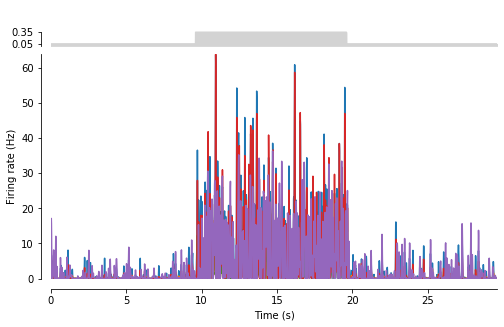

In [5]:
Rs, As, I1s, I2s, us, after_kinetics = contrast_adaptation_kinetic_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=40)

In [6]:
after_filters = (after_kinetics * model.state_dict()['amacrine.1.filter'].cpu().detach().numpy().squeeze((-1,-2))).sum(-2)

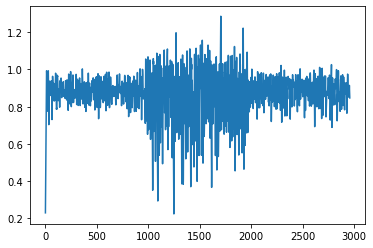

In [11]:
plt.plot(after_filters[:,0])

In [8]:
model.state_dict()['bipolar.0.convs.6.bias']

tensor([ 0.0459,  1.1781,  0.0412, -1.8412, -0.5664, -1.7243, -0.3753, -1.0030],
       device='cuda:3')

In [23]:
model.state_dict()['amacrine.2.convs.4.bias']

tensor([ 0.1298,  0.0233, -0.1376, -0.1498,  0.4251,  0.7035, -0.4056, -0.2308],
       device='cuda:3')

In [53]:
model.state_dict().keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.1.sigma', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinet_scale.scale_param', 'kinet_scale.shift_param', 'amacrine.1.filter', 'amacrine.2.convs.0.weight', 'amacrine.2.convs.1.weight', 'amacrine.2.convs.2.weight', 'amacrine.2.convs.3.weight', 'amacrine.2.convs.4.weight', 'amacrine.2.convs.4.bias', 'amacrine.4.sigma', 'ganglion.0.weight'])